# USD MSADS 505 Final Project - Team 3
# Caleb McCurdy, Jesse Gutierrez, and Jessica Hin

# Part 1 Data preparation

In [1]:
# import the needed packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sma
import klib

%matplotlib inline
from sklearn.model_selection import train_test_split 

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


In [3]:
os.getcwd()

'/Users/calebmccurdy/Desktop/USD/ADS 505/Project'

In [4]:
bank = pd.read_csv('bank-full.csv', sep=";")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
bank['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

<Axes: title={'center': 'Feature-correlation (pearson)'}>

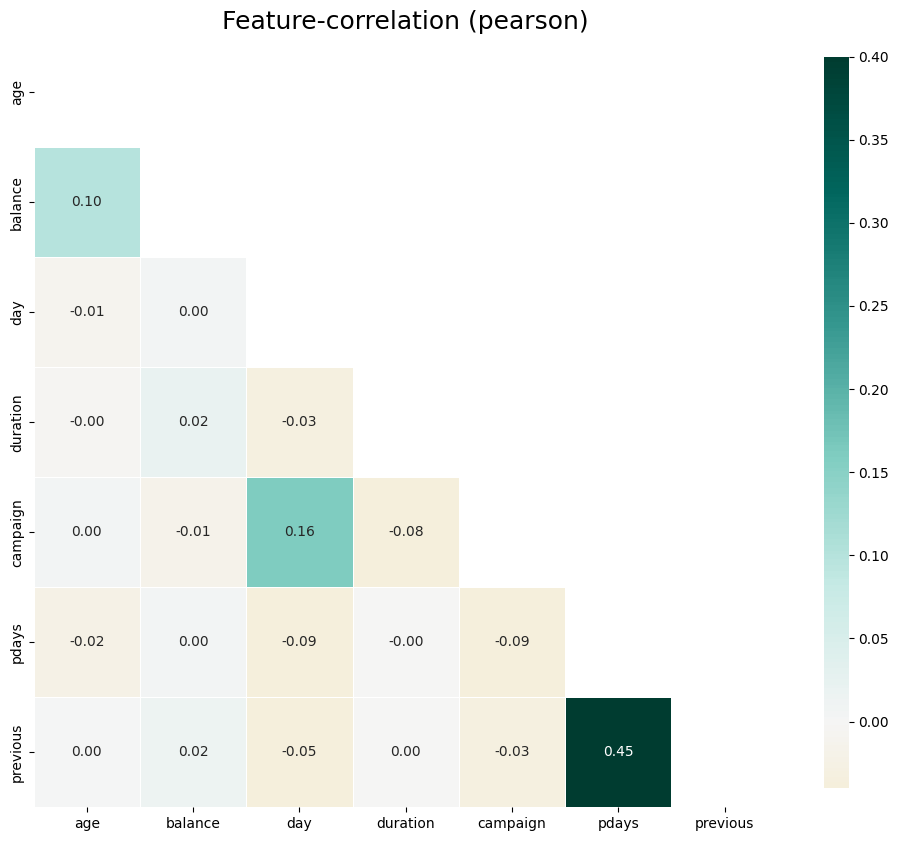

In [7]:
klib.corr_plot(bank)

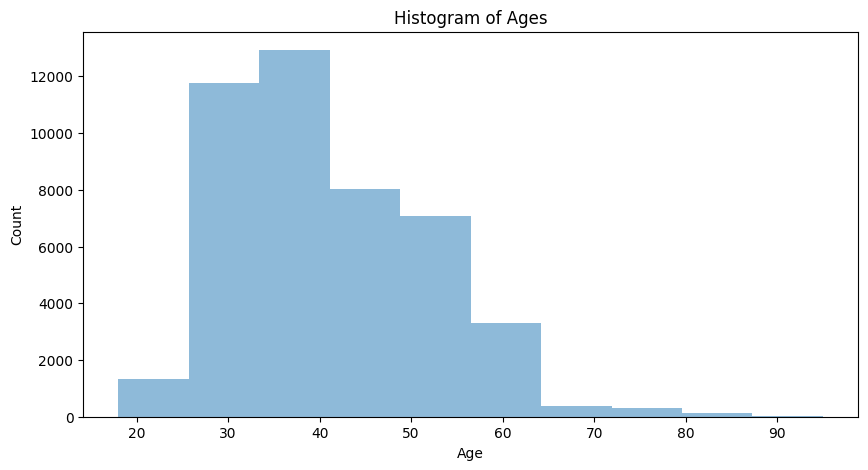

In [10]:
# plot the histogram of the ages
plt.figure(figsize = (10,5))
plt.hist(bank['age'], alpha = 0.5, label='Age')
plt.xlabel("Age")
plt.ylabel("Count")
plt.ticklabel_format(style='plain')
plt.title('Histogram of Ages')
plt.show()

<Axes: title={'center': 'Normalized Bar Graph of Job Status and Term Deposit Subscription'}, xlabel='job'>

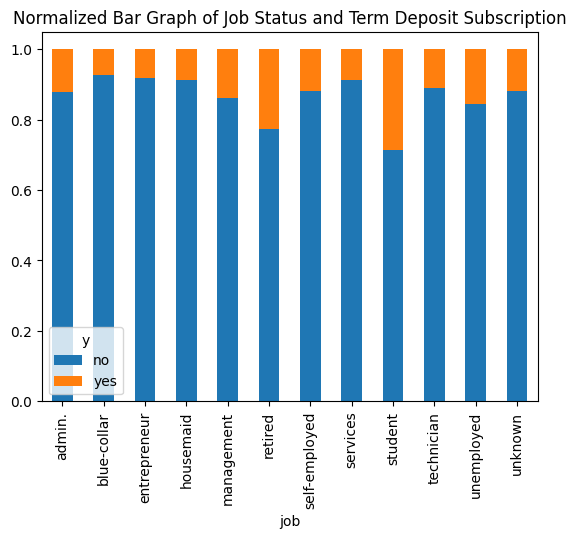

In [14]:
# create a normalized bar graph of outcome for each job status
crosstab_01 = pd.crosstab(bank['job'], bank['y'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1),axis = 0)
crosstab_norm.plot(kind='bar', stacked = True, title = 'Normalized Bar Graph of Job Status and Term Deposit Subscription')